# Constructing Classification model
- Selecting models which are the most appropriate
- Constructing the model 
- Confirming model assumptions
- Evaluating model results to determine how well a model fits the data


My goal is to predict whether an employee leaves the company, which is a categorical outcome variable. So this task involves classification. More specifically, this involves binary classification, since the outcome variable `left` can be either 1 (indicating employee left) or 0 (indicating employee didn't leave). So I will build a Logistic Regression model some Tree-based Machine Learning models like Decision Tree, Random Forest anf XGBoost. Compare them against each other to find the best performing model.

### Importing packages

In [5]:
 # For data manipulation
import numpy as np
import pandas as pd

# For data visualization
import matplotlib.pyplot as plt
import seaborn as sns

# For displaying all of the columns in dataframes
pd.set_option('display.max_columns', None)

# For data modeling
from xgboost import XGBClassifier
from xgboost import XGBRegressor
from xgboost import plot_importance

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

# For metrics and helpful functions
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score,\
f1_score, confusion_matrix, ConfusionMatrixDisplay, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.tree import plot_tree

# For saving models
import joblib

In [6]:
# Importing custom functions from utils file that I created for this project
from utils import explore_outlier
from utils import remove_outlier
from utils import make_results
from utils import get_scores
from utils import stratified_split_no_data_leakage   
from utils import plot_classification_matrix

### Loading the dataset

In [7]:
# Loading dataset into a dataframe
df1 = pd.read_csv("hr_dataset_2.csv")

# first few rows of the dataframe
df1.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,department,salary
0,0.38,0.53,2,157,3,0,1,0,sales,low
1,0.80,0.86,5,262,6,0,1,0,sales,medium
2,0.11,0.88,7,272,4,0,1,0,sales,medium
3,0.72,0.87,5,223,5,0,1,0,sales,low
4,0.37,0.52,2,159,3,0,1,0,sales,low


# **Logistic Regression Model**

## 🔎 Model assumptions

**Logistic Regression model assumptions**
- Outcome variable is categorical
- Observations are independent of each other
- No severe multicollinearity among X variables 
- No extreme outliers
- Linear relationship between each X variable and the logit of the outcome variable
- Sufficiently large sample size 





### Converting categorical columns to numerical/boolean columns

Before splitting the data, I will encode the non-numeric variables. There are two: `department` and `salary`. 

`department` is a categorical variable, which means I can dummy it for modeling. 

`salary` is categorical too, but it's ordinal. There's a hierarchy to the categories, so it's better not to dummy this column, but rather to convert the levels to numbers, 0-2.

In [8]:
# Copy the dataframe
df_enc = df1.copy()

# Encode the `salary` column as an ordinal numeric category
df_enc['salary'] = (
    df_enc['salary'].astype('category')
    .cat.set_categories(['low', 'medium', 'high'])
    .cat.codes
)

# Dummy encode the `department` column
df_enc = pd.get_dummies(df_enc, drop_first=False)

# Display the new dataframe
df_enc.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
1,0.80,0.86,5,262,6,0,1,0,1,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


Creating a heatmap to visualize how correlated variables are. Considering the variables I am interested in examining correlations between.

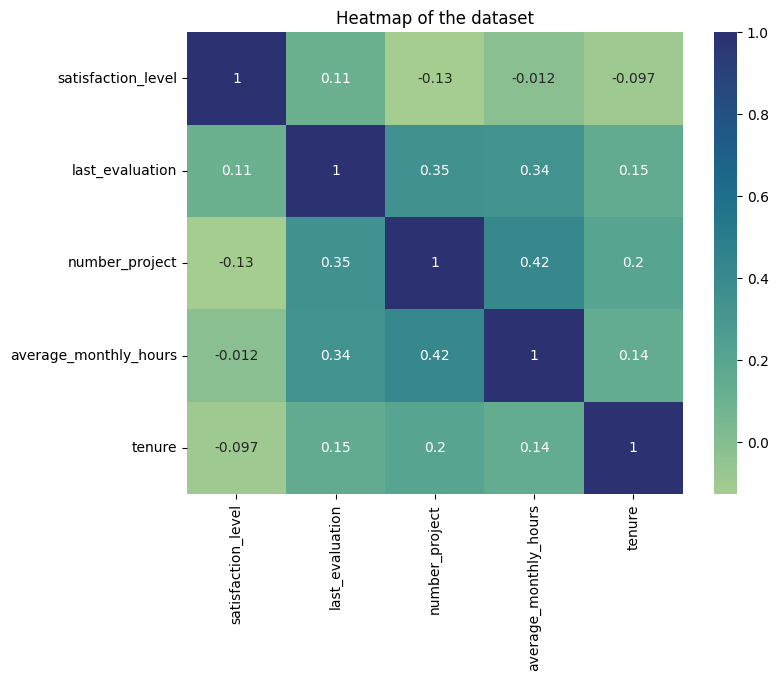

In [9]:
# Heatmap to visualize how correlated variables are
plt.figure(figsize=(8, 6))
sns.heatmap(df_enc[['satisfaction_level', 'last_evaluation', 'number_project', 'average_monthly_hours', 'tenure']]
            .corr(), annot=True, cmap="crest")
plt.title('Heatmap of the dataset')
plt.show()

Stacked bar plot to visualize number of employees across department, comparing those who left with those who didn't.

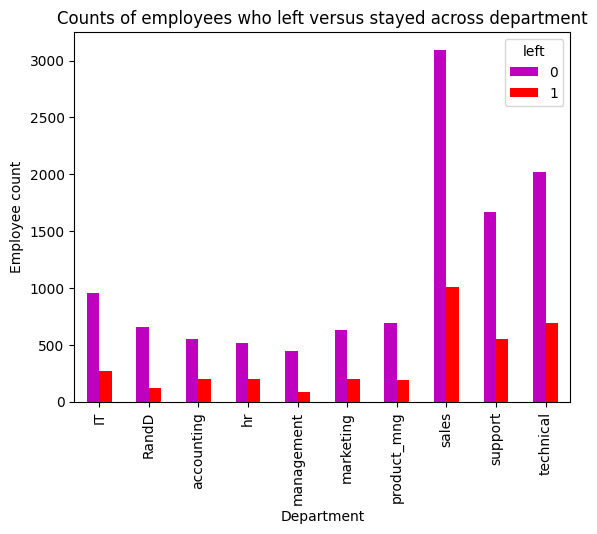

In [10]:
# In the legend, 
# 0 (purple color) represents employees who did not leave
# 1 (red color) represents employees who left
pd.crosstab(df1['department'], df1['left']).plot(kind ='bar',color='mr')
plt.title('Counts of employees who left versus stayed across department')
plt.ylabel('Employee count')
plt.xlabel('Department')
plt.show()

Since logistic regression is quite sensitive to outliers, it would be a good idea at this stage to remove the outliers in the `tenure` column that were identified earlier.

In [11]:
# Using the function from "utils.py" file to remove outliers in `tenure` column
df_logreg = remove_outlier(df_enc, 'tenure')
df_logreg.head()

,satisfaction_level,last_evaluation,number_project,average_monthly_hours,tenure,work_accident,left,promotion_last_5years,salary,department_IT,department_RandD,department_accounting,department_hr,department_management,department_marketing,department_product_mng,department_sales,department_support,department_technical
0,0.38,0.53,2,157,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
2,0.11,0.88,7,272,4,0,1,0,1,False,False,False,False,False,False,False,True,False,False
3,0.72,0.87,5,223,5,0,1,0,0,False,False,False,False,False,False,False,True,False,False
4,0.37,0.52,2,159,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False
5,0.41,0.50,2,153,3,0,1,0,0,False,False,False,False,False,False,False,True,False,False


Isolating the outcome variable, which is the variable I want the model to predict.

In [12]:
# Isolating the outcome variable
y = df_logreg['left']

# First few rows of the outcome variable
y.head() 

0    1
2    1
3    1
4    1
5    1
Name: left, dtype: int64

Spliting the data into training set and testing set. Stratifying based on the values in `y`, since the classes are unbalanced.

In [13]:
# Spliting the data into training set and testing set
X_train, X_test, y_train, y_test = stratified_split_no_data_leakage(df_logreg, target_col='left')

Constructing and fitting a logistic regression model.

In [14]:
log_clf = LogisticRegression(random_state=42, max_iter=1000).fit(X_train, y_train)

Testing the logistic regression model on the test set.

In [15]:
y_pred = log_clf.predict(X_test)

Confusion matrix to visualize the results of the logistic regression model. 

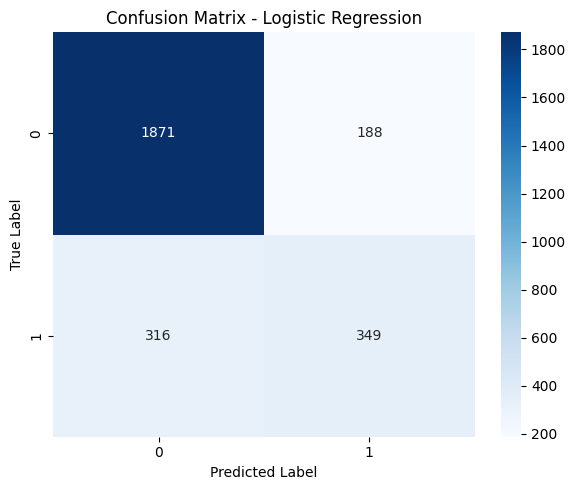

In [16]:
# Display the classification matrix
plot_classification_matrix(log_clf, X_test, y_test, model_name='Logistic Regression')

- The upper-left quadrant displays the number of true negatives.
- The upper-right quadrant displays the number of false positives.
- The bottom-left quadrant displays the number of false negatives.
- The bottom-right quadrant displays the number of true positives.

True negatives: The number of people who did not leave that the model accurately predicted did not leave.

False positives: The number of people who did not leave the model inaccurately predicted as leaving.

False negatives: The number of people who left that the model inaccurately predicted did not leave

True positives: The number of people who left the model accurately predicted as leaving

A perfect model would yield all true negatives and true positives, and no false negatives or false positives.

Creating a classification report that includes precision, recall, f1-score, and accuracy metrics to evaluate the performance of the logistic regression model.

Checking the class balance in the data. In other words, checking the value counts in the `left` column. Since this is a binary classification task, the class balance informs the way you interpret accuracy metrics.

In [17]:
df_logreg['left'].value_counts(normalize=True)

left
0    0.757053
1    0.242947
Name: proportion, dtype: float64

There is an approximately 76%-24% split. So the data is not perfectly balanced, but it is not too imbalanced. In this case, I can use this data without modifying the class balance and continue evaluating the model.

In [18]:
# Creating classification report for logistic regression model
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.86      0.91      0.88      2059
    Predicted would leave       0.65      0.52      0.58       665

                 accuracy                           0.81      2724
                macro avg       0.75      0.72      0.73      2724
             weighted avg       0.81      0.81      0.81      2724



The classification report above shows that the logistic regression model achieved a precision of 86%, recall of 91%, f1-score of 88% (all weighted averages), and accuracy of 81%. However, if it's most important to predict employees who leave, then the scores are significantly lower.

### **Tree-based Models**
Decision Tree, Random Forest and XGBoost. 

#### Decision tree

Constructing a decision tree model and setting-up cross-validated grid-search to exhuastively search for the best model parameters.

In [19]:
# Splitting the data into training set and testing set
X_train, X_test, y_train, y_test = stratified_split_no_data_leakage(df_enc, target_col='left')

In [20]:
# Instantiating model
tree1 = DecisionTreeClassifier(random_state=0)

# Assigning a dictionary of hyperparameters to search over
cv_params = {'max_depth':[4, 6, 8, None],
             'min_samples_leaf': [2, 5, 1],
             'min_samples_split': [2, 4, 6]
             }

# Assigning a dictionary of scoring metrics to capture
scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1',
           'roc_auc': 'roc_auc'}

# Instantiating GridSearch
tree1_cv = GridSearchCV(tree1, cv_params, scoring=scoring, cv=4, refit='roc_auc')

Fitting the decision tree model to the training data.

In [23]:
%%time
# Fitting the model to the training data
tree1_cv.fit(X_train, y_train)

CPU times: total: 10.3 s
Wall time: 10.4 s


GridSearchCV(cv=4, estimator=DecisionTreeClassifier(random_state=0),
             param_grid={'max_depth': [4, 6, 8, None],
                         'min_samples_leaf': [2, 5, 1],
                         'min_samples_split': [2, 4, 6]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [24]:
# Saving the model to a file
joblib.dump(tree1_cv , 'tree1_cv.pkl')

['tree1_cv.pkl']

Identifying optimal values for the decision tree parameters.

In [25]:
# Loading the model from a file
tree1_cv = joblib.load('tree1_cv.pkl')

# Best parameters
tree1_cv.best_params_

{'max_depth': None, 'min_samples_leaf': 5, 'min_samples_split': 2}

In [26]:
# Best AUC score on CV
tree1_cv.best_score_

np.float64(0.9835012685931266)

This is a strong AUC score, which shows that this model can predict employees who will leave very well. 

Using the function 'make_results' fram utils.py file to get all the scores from grid search.

In [27]:
# Get all CV scores
tree1_model = tree1_cv.best_estimator_
tree1_cv_results = make_results('decision tree cv', tree1_cv, 'auc')
tree1_cv_results

,model,precision,recall,F1,accuracy,auc
0,decision tree cv,0.948726,0.943019,0.945782,0.9741,0.983501


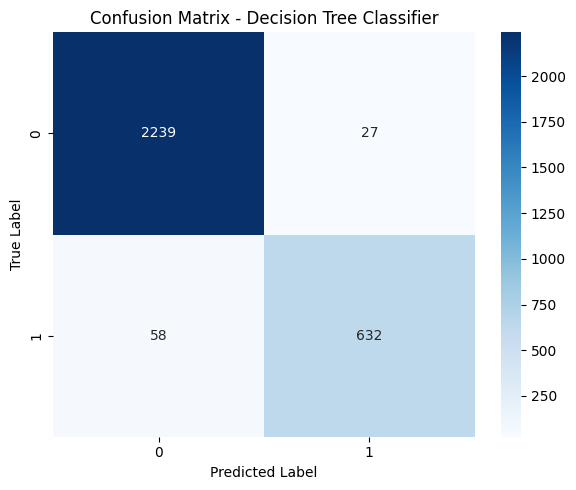

In [28]:
# Display the confusion_matrix
plot_classification_matrix(tree1_cv, X_test, y_test, model_name='Decision Tree Classifier')

All of these scores from the decision tree model are strong indicators of good model performance. 

Decision trees can be vulnerable to overfitting, and random forests avoid overfitting by incorporating multiple trees to make predictions. Next I will construct a random forest model.

#### Random forest - Round 1

Constructing a random forest model, cross-validating with grid-search to exhuastively search for the best model parameters.

In [29]:
# Instantiating model
rf1 = RandomForestClassifier(random_state=0)

# Assigning a dictionary of hyperparameters to search over
cv_params = {'max_depth': [3,5, None], 
             'max_features': [1.0],
             'max_samples': [0.7, 1.0],
             'min_samples_leaf': [1,2,3],
             'min_samples_split': [2,3,4],
             'n_estimators': [300, 500],
             }  

# Assigning a dictionary of scoring metrics to capture
scoring = {'accuracy': 'accuracy',
           'precision': 'precision',
           'recall': 'recall',
           'f1': 'f1',
           'roc_auc': 'roc_auc'}

# Instantiating GridSearch
rf1_cv = GridSearchCV(rf1, cv_params, scoring=scoring, cv=4, refit='roc_auc')

Fitting the random forest model to the training data.

In [30]:
%%time
rf1_cv.fit(X_train, y_train)

CPU times: total: 53min 31s
Wall time: 54min 23s


GridSearchCV(cv=4, estimator=RandomForestClassifier(random_state=0),
             param_grid={'max_depth': [3, 5, None], 'max_features': [1.0],
                         'max_samples': [0.7, 1.0],
                         'min_samples_leaf': [1, 2, 3],
                         'min_samples_split': [2, 3, 4],
                         'n_estimators': [300, 500]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

Saving the random forest gridsearchCV model

In [31]:
joblib.dump(rf1_cv , 'rf1_cv.pkl')

['rf1_cv.pkl']

Loading the random forest gridsearchCV model

In [32]:
rf1_cv = joblib.load('rf1_cv.pkl')

Best AUC score achieved by the random forest model on the training set.

In [33]:
# Best AUC score on CV
rf1_cv.best_score_

np.float64(0.9921069429725592)

Optimal values for the parameters of the random forest model.

In [34]:
# parammeters on CV
rf1_cv.best_params_

{'max_depth': None,
 'max_features': 1.0,
 'max_samples': 0.7,
 'min_samples_leaf': 3,
 'min_samples_split': 2,
 'n_estimators': 500}

Confusion matrix

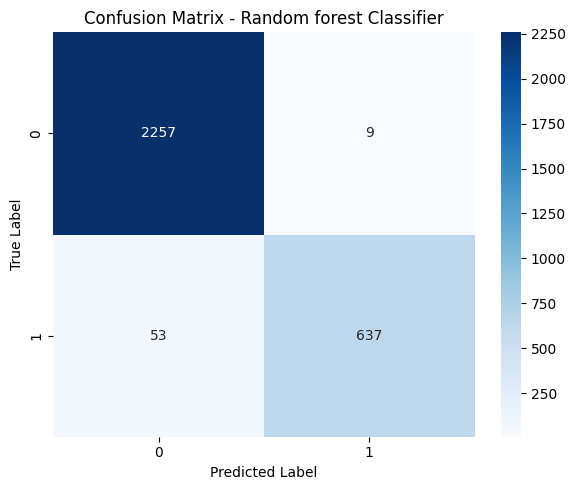

In [35]:
# Display the confusion_matrix
rf1_model = rf1_cv.best_estimator_
plot_classification_matrix(rf1_model, X_test, y_test, model_name='Random forest Classifier')

### **XGBoost Model**

Constructing a XGBoost model and setting-up cross-validated grid-search to exhuastively search for the best model parameters.

In [36]:
# Splitting the data into training set and testing set
X_train, X_test, y_train, y_test = stratified_split_no_data_leakage(df_enc, target_col='left')

In [37]:
# Instantiating XGBoost model
xgb1 = XGBClassifier(use_label_encoder=False, eval_metric='logloss')


# Dictionary of hyperparameters to search over
cv_params = {
    'n_estimators': [100, 200],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.8, 1],
    'colsample_bytree': [0.8, 1]
}


# Dictionary of scoring metrics to capture
scoring = {
    'accuracy' : 'accuracy',
    'f1' : 'f1',
    'precision' : 'precision',
    'recall' : 'recall',
    'roc_auc' : 'roc_auc'
}

# Instantiating GridSearch
xgb1_cv = GridSearchCV(xgb1, cv_params, scoring=scoring, cv=4, refit='roc_auc')

Fitting the XGBoost model to the training data, then saving the best model

In [38]:
%%time
# Fitting the model to the training data
xgb1_cv.fit(X_train, y_train)

c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:23:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:23:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:23:36] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:23:36] WARNING: C:\actions-runner\_w

CPU times: total: 11min 21s
Wall time: 1min 44s


c:\Users\HP\AppData\Local\Programs\Python\Python310\lib\site-packages\xgboost\training.py:183: UserWarning: [16:25:20] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


GridSearchCV(cv=4,
             estimator=XGBClassifier(base_score=None, booster=None,
                                     callbacks=None, colsample_bylevel=None,
                                     colsample_bynode=None,
                                     colsample_bytree=None, device=None,
                                     early_stopping_rounds=None,
                                     enable_categorical=False,
                                     eval_metric='logloss', feature_types=None,
                                     feature_weights=None, gamma=None,
                                     grow_policy=None, importance_type=None,
                                     interaction_constraint...
                                     missing=nan, monotone_constraints=None,
                                     multi_strategy=None, n_estimators=None,
                                     n_jobs=None, num_parallel_tree=None, ...),
             param_grid={'colsample_bytree': [0.8, 1],
                         'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7], 'n_estimators': [100, 200],
                         'subsample': [0.8, 1]},
             refit='roc_auc',
             scoring={'accuracy': 'accuracy', 'f1': 'f1',
                      'precision': 'precision', 'recall': 'recall',
                      'roc_auc': 'roc_auc'})

In [39]:
# Saving the model to a file    
joblib.dump(xgb1_cv , 'xgb1_cv.pkl')

['xgb1_cv.pkl']

Loading the saved cv model

In [40]:
# Loading the model from a file
xgb1_cv = joblib.load('xgb1_cv.pkl')

Best AUC score achieved by the XGBoost model on training set

In [41]:
# Best AUC score on CV
xgb1_cv.best_score_

np.float64(0.9941243059267733)

Optimal values for the parameters of the XGBoost model 

In [42]:
# Checking the best parameters 
xgb1_cv.best_params_

{'colsample_bytree': 0.8,
 'learning_rate': 0.1,
 'max_depth': 7,
 'n_estimators': 100,
 'subsample': 0.8}

Predicting and evaluating the XGBoost model on testing set

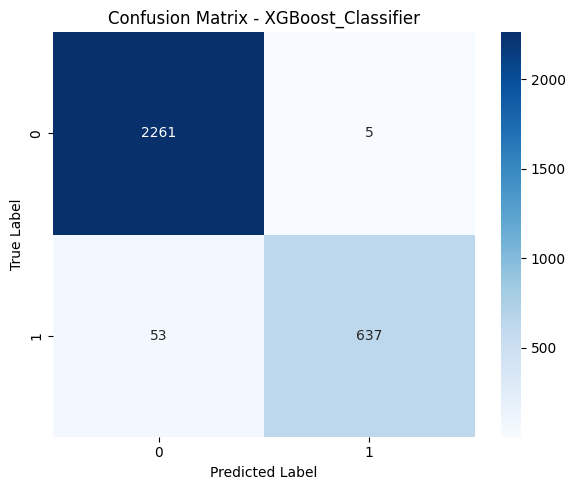

In [43]:
xgb1_model = xgb1_cv.best_estimator_
y_pred = xgb1_model.predict(X_test)

# Confusion matrix
plot_classification_matrix(xgb1_model, X_test, y_test, model_name='XGBoost_Classifier')


In [44]:
# Classification report for XGBoost model
target_names = ['Predicted would not leave', 'Predicted would leave']
print(classification_report(y_test, y_pred, target_names=target_names))

                           precision    recall  f1-score   support

Predicted would not leave       0.98      1.00      0.99      2266
    Predicted would leave       0.99      0.92      0.96       690

                 accuracy                           0.98      2956
                macro avg       0.98      0.96      0.97      2956
             weighted avg       0.98      0.98      0.98      2956



The test scores are very similar to the validation scores, which is good. This appears to be a strong model. Since this test set was only used for this model, I can be confident that my model's performance on this data is representative of how it will perform on new, unseeen data.

Collecting the evaluation scores on the training set for the decision tree, random forest models and XGBoost model

In [45]:
# All CV scores
tree1_cv_results = make_results('decision tree cv', tree1_cv, 'auc')
rf1_cv_results = make_results('random forest cv', rf1_cv, 'auc')
xgb1_cv_results = make_results('xgboost cv', xgb1_cv, 'auc')
print(tree1_cv_results)
print(rf1_cv_results)
print(xgb1_cv_results)

              model  precision    recall        F1  accuracy       auc
0  decision tree cv   0.948726  0.943019  0.945782    0.9741  0.983501
              model  precision    recall       F1  accuracy       auc
0  random forest cv   0.980054  0.934175  0.95648   0.97962  0.992107
        model  precision    recall        F1  accuracy       auc
0  xgboost cv   0.981948  0.951866  0.966504  0.984205  0.994124


In [ ]:
# Saving the dataset used for training and testing to a CSV file 
df_enc.to_csv('hr_dataset_encoded.csv', index=False)

# These results are too good, there might be some data leakage. I will address this issue in the next step with `Feature Engineering`.